# Cryptocurrency Prophet

In [1]:
!pip install pandas prophet requests ipywidgets

In [2]:
#@title Using Python Prophet and CoinCap for crpytocurrency predictions.
#@markdown We will create a list of all the available currencies via CoinCap.<br>
#@markdown We use historical pricing on a 1 day basis as our dataset.

import sys
from datetime import datetime
from typing import List, Set

import pandas as pd
import requests
from prophet import Prophet


proxies = {
    # 'https': 'https://116.254.116.99:8080'
}

requests.Session().get('https://api.coincap.io/v2/assets', proxies=proxies)

def get_supported_currencies_datasets() -> List[str]:
    try:      
      datasets = requests.Session().get('https://api.coincap.io/v2/assets', proxies=proxies).json()
    except Exception as e:
      print(e)
      print('Failed to get the list of currencies from coincap. Please retry.')
      return
    coins = [f['id'] for f in datasets['data']]
    return coins


def predict_currencies(currencies: Set[str]):
    currencies = [c for c in currencies if c]
    futures = []
    forecasts = []
    for currency_name in currencies:
        # Get the dataset
        try:
          historical_data = requests.Session().get(f'https://api.coincap.io/v2/assets/{currency_name}/history?interval=d1', proxies=proxies).json()[
              'data']
        except Exception:
          print(f'Failed to get the data for {currency_name} from coincap. Please retry.')
          return
        
        df = pd.DataFrame.from_dict(historical_data)
        print("Historical Data: ")
        print(df)

        # Normalization
        print("Normalizing the data...")
        df.rename(columns={"time": "ds", "priceUsd": "y"}, inplace=True)
        # Stripping timezone
        df['ds'] = df['ds'].apply(lambda timestamp: datetime.fromtimestamp(int(timestamp) / 1000))
        df['ds'] = df['ds'].apply(lambda d: d.replace(tzinfo=None))
        df['ds'] = pd.to_datetime(df['ds'])
        df['ds'].dt.tz_localize(None)
        print("Normalized Data: ")
        print(df)

        # Fit
        print("Creating a time-series model...")

        # Predictions
        m = Prophet(seasonality_mode='multiplicative').fit(df)
        future = m.make_future_dataframe(periods=14, include_history=True)
        forecast = m.predict(future)
        futures.append(future)
        forecasts.append(forecast)
        print(f"Forecast for {currency_name}: ", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
        m.plot(forecast).show()
        m.plot_components(forecast).show()
    return forecasts

In [3]:
#@title Let's list all currencies on CoinCap
#@markdown You can select multiple values.
supported_currencies = get_supported_currencies_datasets()
if supported_currencies:
  import ipywidgets as widgets
  selection = widgets.SelectMultiple(
      options=supported_currencies,
      value=['ethereum'],
      rows=20,
      description='Currencies',
      disabled=False
  )
  display(selection)

SelectMultiple(description='Currencies', index=(1,), options=('bitcoin', 'ethereum', 'tether', 'binance-coin',…

Predicting  ('ethereum',)
Historical Data: 
                  priceUsd           time                      date
0    1242.4633877093333069  1611360000000  2021-01-23T00:00:00.000Z
1    1319.1470063194661870  1611446400000  2021-01-24T00:00:00.000Z
2    1403.5521251366696822  1611532800000  2021-01-25T00:00:00.000Z
3    1326.0821004771740927  1611619200000  2021-01-26T00:00:00.000Z
4    1282.1208813689195151  1611705600000  2021-01-27T00:00:00.000Z
..                     ...            ...                       ...
359  3261.6929948432220962  1642377600000  2022-01-17T00:00:00.000Z
360  3167.5749588827801796  1642464000000  2022-01-18T00:00:00.000Z
361  3122.6576554892370910  1642550400000  2022-01-19T00:00:00.000Z
362  3158.7399862396467749  1642636800000  2022-01-20T00:00:00.000Z
363  2825.3491079852757180  1642723200000  2022-01-21T00:00:00.000Z

[364 rows x 3 columns]
Normalizing the data...
Normalized Data: 
                         y         ds                      date
0    1242.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecast for ethereum:              ds         yhat   yhat_lower   yhat_upper
373 2022-01-31  3628.480175  3095.992892  4109.132215
374 2022-02-01  3610.014849  3038.372149  4131.939338
375 2022-02-02  3620.359784  3117.177914  4153.666675
376 2022-02-03  3624.210748  3100.759683  4159.657677
377 2022-02-04  3582.847587  3045.656941  4071.134898


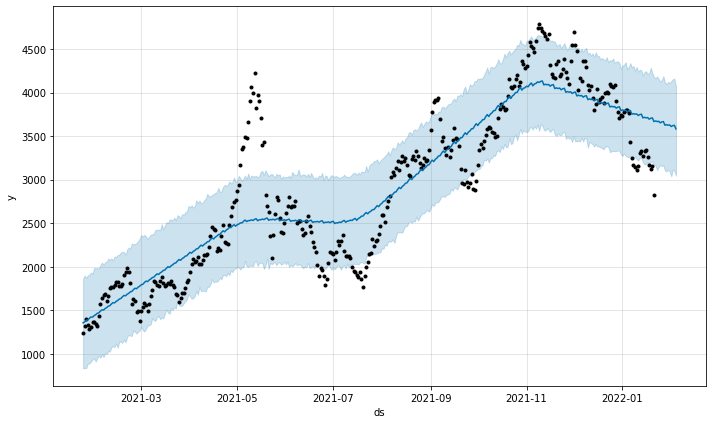

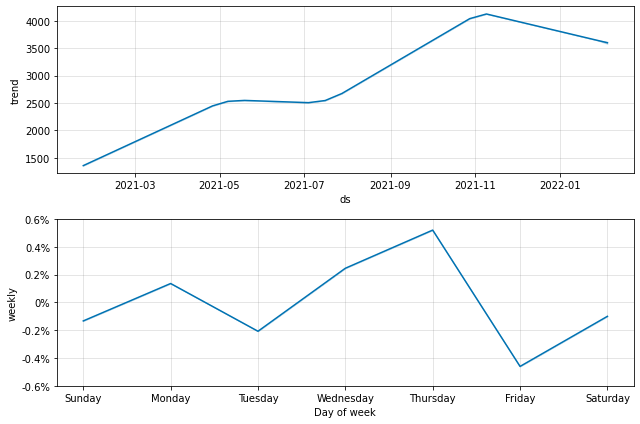

In [4]:
#@title Run the predictions on the selected currencies
currencies = selection.value
print('Predicting ',currencies)
forecasts = predict_currencies(selection.value)